<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/TensorFlow/TensorFlow_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

def my_generator(my_array):
    i = 0
    while True:
        yield my_array[i:i+2, :]
        i += 1

In [ ]:
test_array = np.array([[10.0, 2.0],
                       [15, 6.0],
                       [3.2, -1.5],
                       [-3, -2]], np.float32)

output = my_generator(test_array)

In [ ]:
next(output)

array([], shape=(0, 2), dtype=float32)

In [ ]:
!mkdir working_data
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv -P ./working_data

--2022-06-06 04:27:03--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23278 (23K) [text/plain]
Saving to: ‘./working_data/pima-indians-diabetes.data.csv’

pima-indians-diabet 100%[===================>]  22.73K  --.-KB/s    in 0.001s  

2022-06-06 04:27:04 (15.3 MB/s) - ‘./working_data/pima-indians-diabetes.data.csv’ saved [23278/23278]



Reading the whole dataset into memory

In [ ]:
import csv
import pathlib
import pandas as pd

file_path = pathlib.Path('working_data')
file_name = 'pima-indians-diabetes.data.csv'

col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
             'Insulin', 'BMI','DiabetesPedigree', 'Age', 'Outcome']

pd.read_csv(file_path / file_name, names=col_names)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Use generator to stream the data file

In [ ]:
with open(file_path/file_name, newline='\n') as csvfile:
    f = csv.reader(csvfile, delimiter=',')
    for row in f:
        print(','.join(row))

In [ ]:
def stream_file(file_handle):
    for row in file_handle:
        yield row.rstrip("\n")

with open(file_path/file_name,newline='\n') as handle:
    for part in stream_file(handle):
        print(part)

###Setting up a pattern for file names

In [ ]:
!wget https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv

--2022-06-06 04:27:28--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54634311 (52M) [text/plain]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv 100%[===================>]  52.10M   196MB/s    in 0.3s    

2022-06-06 04:27:28 (196 MB/s) - ‘owid-covid-data.csv’ saved [54634311/54634311]



In [ ]:
!wc -l owid-covid-data.csv

191612 owid-covid-data.csv


In [ ]:
!head -3 owid-covid-data.csv

iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundre

###Splitting a single csv file into multiple csv files

In [ ]:
!cat owid-covid-data.csv | parallel --header : --pipe -N2000 'cat > ./covid/owid-covid-data-part00{#}.csv'

In [ ]:
! tar xvf covid.tar.gz

###Creating a file pattern object using tf.io

In [ ]:
import tensorflow as tf

base_dir = 'covid'
file_pattern = 'owid-covid-data-part*'
files = tf.io.gfile.glob(base_dir + '/' + file_pattern)

###Creating a streaming dataset object

In [ ]:
csv_dataset = tf.data.experimental.make_csv_dataset(files, header=True, 
                                                    batch_size=5, label_name='new_deaths',
                                                    num_epochs=1, ignore_errors=True)

for features, target in csv_dataset.take(1):
    print(f"Target: {target}")
    print("Features:")
    for k, v in features.items():
        print('    {!r:20s}: {}'.format(k,v))

Target: [42.  3.  0.  0.  1.]
Features:
    'iso_code'          : [b'KGZ' b'MOZ' b'NAM' b'KWT' b'KNA']
    'continent'         : [b'Asia' b'Africa' b'Africa' b'Asia' b'North America']
    'location'          : [b'Kyrgyzstan' b'Mozambique' b'Namibia' b'Kuwait' b'Saint Kitts and Nevis']
    'date'              : [b'2020-07-21' b'2022-01-11' b'2020-07-12' b'2021-12-17' b'2022-02-07']
    'total_cases'       : [ 28251. 212859.    785. 413972.   5484.]
    'new_cases'         : [1108. 1868.  117.   81.    9.]
    'new_cases_smoothed': [2401.    2359.      53.286   47.857    8.857]
    'total_deaths'      : [1.079e+03 2.099e+03 1.000e+00 2.466e+03 3.800e+01]
    'new_deaths_smoothed': [132.857   8.143   0.      0.      0.714]
    'total_cases_per_million': [  4262.149   6618.123    303.4    95637.5   102416.62 ]
    'new_cases_per_million': [167.161  58.079  45.22   18.713 168.08 ]
    'new_cases_smoothed_per_million': [362.232  73.345  20.595  11.056 165.412]
    'total_deaths_per_million':

###Streaming a csv dataset

In [ ]:
features, label = next(iter(csv_dataset))

In [ ]:
print(label)

tf.Tensor([ 0.  0.  2. 26. 74.], shape=(5,), dtype=float32)


###Download flower images dataset

In [7]:
import tensorflow as tf

data_dir = tf.keras.utils.get_file('flower_photos', 
                                   'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                   untar=True)

228827136/228813984 [==============================] - 1s 0us/step


In [16]:
!ls ~/.keras/datasets/ -al

total 446912
drwxr-xr-x 2 root root      4096 Jun  8 03:05 .
drwxr-xr-x 3 root root      4096 Jun  8 03:05 ..
-rw-r--r-- 1 root root 228813984 Jun  8 03:05 flower_photos
-rw-r--r-- 1 root root 228813984 Jun  8 03:05 flower_photos.tar.gz


In [ ]:
!tar xvf ~/.keras/datasets/flower_photos

In [25]:
!cp ~/.keras/datasets/flower_photos.tar.gz .

In [ ]:
!tar xvf flower_photos.tar.gz

In [27]:
!ls ./flower_photos/ -l

total 608
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  49152 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  36864 Feb 10  2016 tulips


###Three steps to streaming the images
1. Create an ImageDataGenerator object and specify normalization parameters.

In [28]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

datagen_kwargs = dict(rescale=1./255, validation_split=0.2)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

2. Connect the ImageDataGenerator object ot the data source and specify parameters to resize the images to a fixed dimension

In [37]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                       interpolation='bilinear')

data_dir = './flower_photos'

train_generator = train_datagen.flow_from_directory(data_dir, subset="training",
                                                    shuffle=True, **dataflow_kwargs)

valid_generator = train_datagen.flow_from_directory(data_dir, subset="validation",
                                                    shuffle=False, **dataflow_kwargs)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


3. Prepare a map for indexing the labels

In [35]:
idx_labels = dict((v, k) for k, v in train_generator.class_indices.items())
print(idx_labels)

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}


In [36]:
# each label is encoded with 1-hot encoding
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 5)


###Inspecting resized images

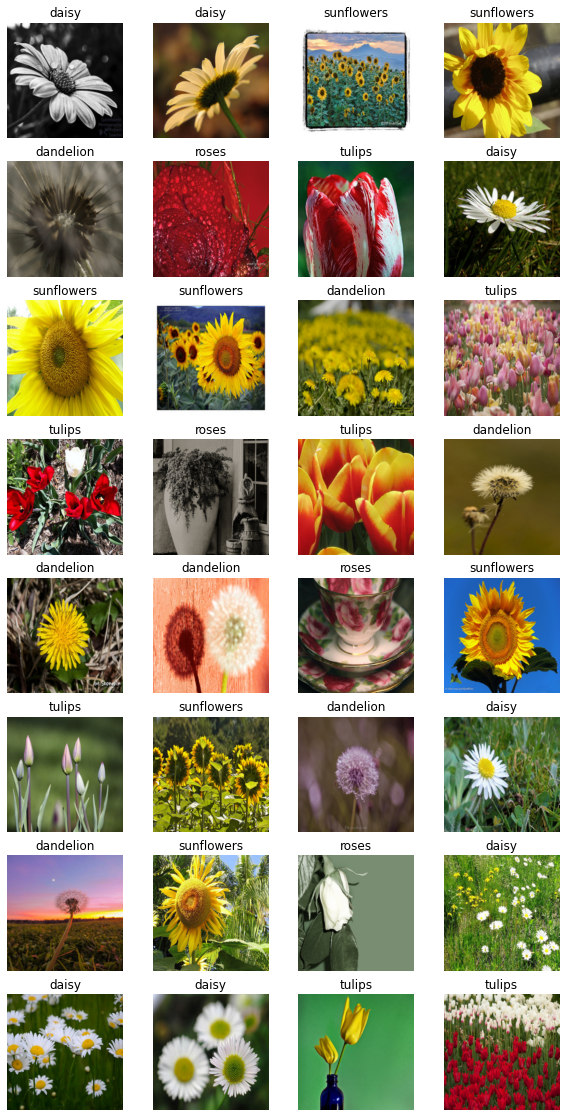

In [40]:
import matplotlib.pyplot as plt
import numpy as np

image_batch, label_batch = next(iter(train_generator))
fig, axes = plt.subplots(8, 4, figsize=(10, 20))
axes = axes.flatten()
for img, lbl, ax in zip(image_batch, label_batch, axes):
    ax.imshow(img)
    label_ = np.argmax(lbl)
    label = idx_labels[label_]
    ax.set_title(label)
    ax.axis('off')
plt.show()